# Анализ Upsell-а в кредитовании

**Введение:**

Данное задание посвящено анализу перекрестных продаж (Upsell) в сфере кредитования Тинькофф Банка.

**Цель:**

Определить ключевые факторы, влияющие на выбор клиентом вида кредитования, чтобы
оптимизировать процесс Upsell-а.

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns

%config InlineBackend.figure_formats = ["png"]

def read(n: str, **kwargs):
    return pl.read_csv(f"../data/{n}", **kwargs).to_pandas()

data = read("data.csv")
data = data[~data["agreement_product_code"].isin(["To CLC", "To CLR", "Unsuccess"])]
data = data[(data['age'] > 17) & (data['age'] < 71)]

**Переменные:**

| Название переменной | Описание | Единицы измерения |
|---|---|---|
| customer_id | ID клиента | - |
| application_id | ID заявки на кредитование | - |
| application_dttm | Дата подачи заявки | - |
| req_amt | Запрошенная сумма кредитования | Условные денежные единицы |
| req_term | Запрошенный срок кредитования | Месяцы |
| req_product_code | Код запрошенного продукта: CL, CLC, CLR | - |
| monthly_income_amt | Доход клиента в месяц | Условные денежные единицы |
| age | Возраст клиента | Года |
| gender_code | Пол: M - мужчина, F - женщина | - |
| car_flg | Наличие авто: 0 - нет, 1 - есть | - |
| car_price | Цена авто (если известна) | Условные денежные единицы |
| realty_flg | Наличие недвижимости: 0 - нет, 1 - есть | - |
| realty_price | Цена недвижимости (если известна) | Условные денежные единицы |
| cc_flg | Наличие кредитной карты: 0 - нет, 1 - есть | - |
| cl_approve_amt | Одобренная сумма КН | Условные денежные единицы |
| cl_rate | Одобренная ставка КН | - |
| clc_approve_amt | Одобренная сумма КНА | Условные денежные единицы |
| clc_rate | Одобренная ставка КНА | - |
| clr_approve_amt | Одобренная сумма КНН | Условные денежные единицы |
| clr_rate | Одобренная ставка КНН | - |
| cc_approve_amt | Одобренный лимит КК | Условные денежные единицы |
| agreement_id | ID согласования условий | - |
| agreement_dttm | Дата и время согласования условий | - |
| product_sale_priority | Приоритет продажи продуктов на СУ | - |
| agreement_product_code | Код согласованного продукта: CC, CL, CLC, CLR, To CLC, To CLR, Unsuccess | - |
| account_amt | Согласованная сумма открытого счета | Условные денежные единицы |
| account_term | Согласованный срок открытого счета | Месяцы |
| account_rate | Согласованная ставка открытого счета | - |
| success_activate_flg | Флаг успешной активации кредита: 0 - нет, 1 - есть | - |

**Комментарии к заданию:**

1. Выделить целевую аудиторию (ЦА) для каждого вида кредитования.
2. Определить характеристики клиента, которые могут быть связаны с выбором вида кредитования.
3. Сгруппировать данные на уровне клиентов.
4. Провести анализ Upsell-а: как банк стремится получить максимальную выгоду.
5. Провести анализ данных, чтобы выявить ключевые факторы, влияющие на выбор клиента.
6. Подвести итоги исследования, указав полученные результаты, ограничения, возможности для улучшения.

**Примечание:**

В рамках исследования можно сосредоточиться на отдельных аспектах, исследуя их
глубоко.

Как связаны кредитки с с залогом на автомобиль

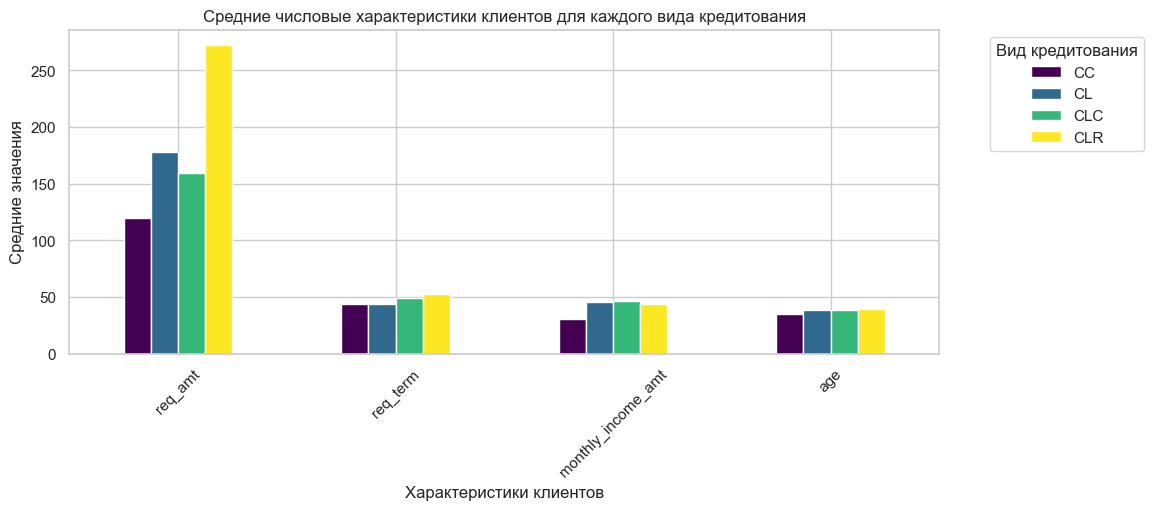

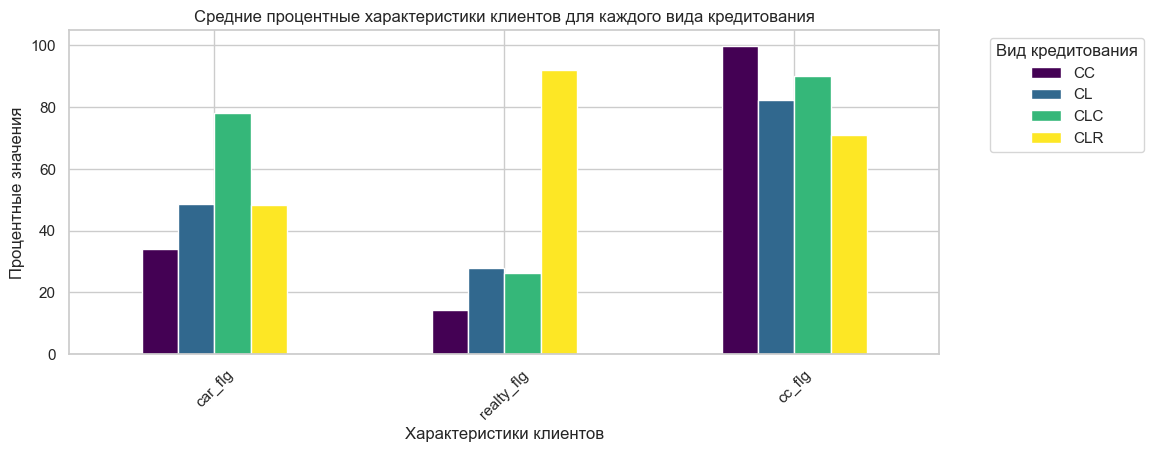

In [26]:
data["application_dttm"] = pd.to_datetime(
    data["application_dttm"], format="%m-%d-%y"
)
data["agreement_dttm"] = pd.to_datetime(
    data["agreement_dttm"], format="%m/%d/%y %H:%M"
)

numeric_cols = [
    "req_amt",
    "req_term",
    "monthly_income_amt",
    "car_price",
    "realty_price",
    "cl_approve_amt",
    "cl_rate",
    "clc_approve_amt",
    "clc_rate",
    "clr_approve_amt",
    "clr_rate",
    "cc_approve_amt",
]

# Используем подход без использования inplace
for col in numeric_cols:
    data[col] = data[col].fillna(data[col].median())

data["gender_code"] = data["gender_code"].fillna(data["gender_code"].mode()[0])
data = data.dropna(subset=["age"])

product_preferences = data["agreement_product_code"].value_counts(
    normalize=True
)
characteristics = data.groupby("agreement_product_code").agg(
    {
        "req_amt": "mean",
        "req_term": "mean",
        "monthly_income_amt": "mean",
        "age": "mean",
        "gender_code": lambda x: x.mode()[0],
        "car_flg": lambda x: (x.mean() * 100),  # Преобразование в проценты
        "realty_flg": lambda x: (x.mean() * 100),  # Преобразование в проценты
        "cc_flg": lambda x: (x.mean() * 100),  # Преобразование в проценты
    }
)

# Настройка стиля графиков
sns.set_theme(style="whitegrid")

# 2.1. Средние числовые характеристики клиентов для каждого вида кредитования
characteristics_numeric = characteristics[
    ["req_amt", "req_term", "monthly_income_amt", "age"]
].T
characteristics_numeric.plot(kind="bar", figsize=(10, 4), colormap="viridis")
plt.title(
    "Средние числовые характеристики клиентов для каждого вида кредитования"
)
plt.xlabel("Характеристики клиентов")
plt.ylabel("Средние значения")
plt.legend(title="Вид кредитования", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.savefig("../assets/image/characteristics_numeric.png", bbox_inches="tight")
plt.show()

# 2.2. Средние процентные характеристики клиентов для каждого вида кредитования
characteristics_percent = characteristics[["car_flg", "realty_flg", "cc_flg"]].T
characteristics_percent.plot(kind="bar", figsize=(10, 4), colormap="viridis")
plt.title(
    "Средние процентные характеристики клиентов для каждого вида кредитования"
)
plt.xlabel("Характеристики клиентов")
plt.ylabel("Процентные значения")
plt.legend(title="Вид кредитования", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.savefig("../assets/image/characteristics_percent.png", bbox_inches="tight")
plt.show()

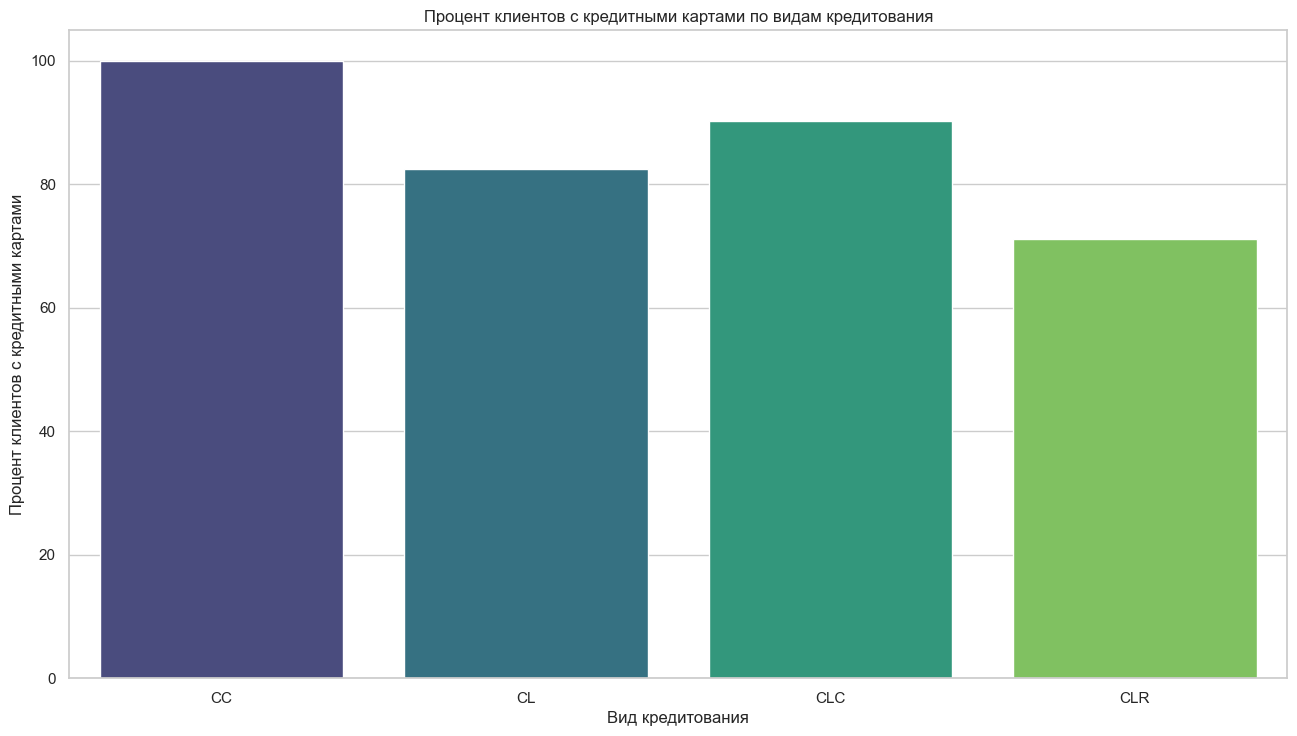

In [27]:
# Анализ наличия кредитных карт среди клиентов по видам кредитования
cc_counts = data.groupby("agreement_product_code")["cc_flg"].sum()
total_counts = data["agreement_product_code"].value_counts()

cc_percentage = (cc_counts / total_counts) * 100

# Создание таблицы с количеством и процентом клиентов с кредитными картами
cc_analysis = pd.DataFrame(
    {
        "Total": total_counts,
        "CC_Count": cc_counts,
        "CC_Percentage": cc_percentage,
    }
)

# Визуализация результатов
plt.figure(figsize=(14, 8))
sns.barplot(
    x=cc_analysis.index,
    y=cc_analysis["CC_Percentage"],
    hue=cc_analysis.index,
    palette="viridis",
    legend=False,
)
plt.title("Процент клиентов с кредитными картами по видам кредитования")
plt.xlabel("Вид кредитования")
plt.ylabel("Процент клиентов с кредитными картами")
plt.show()

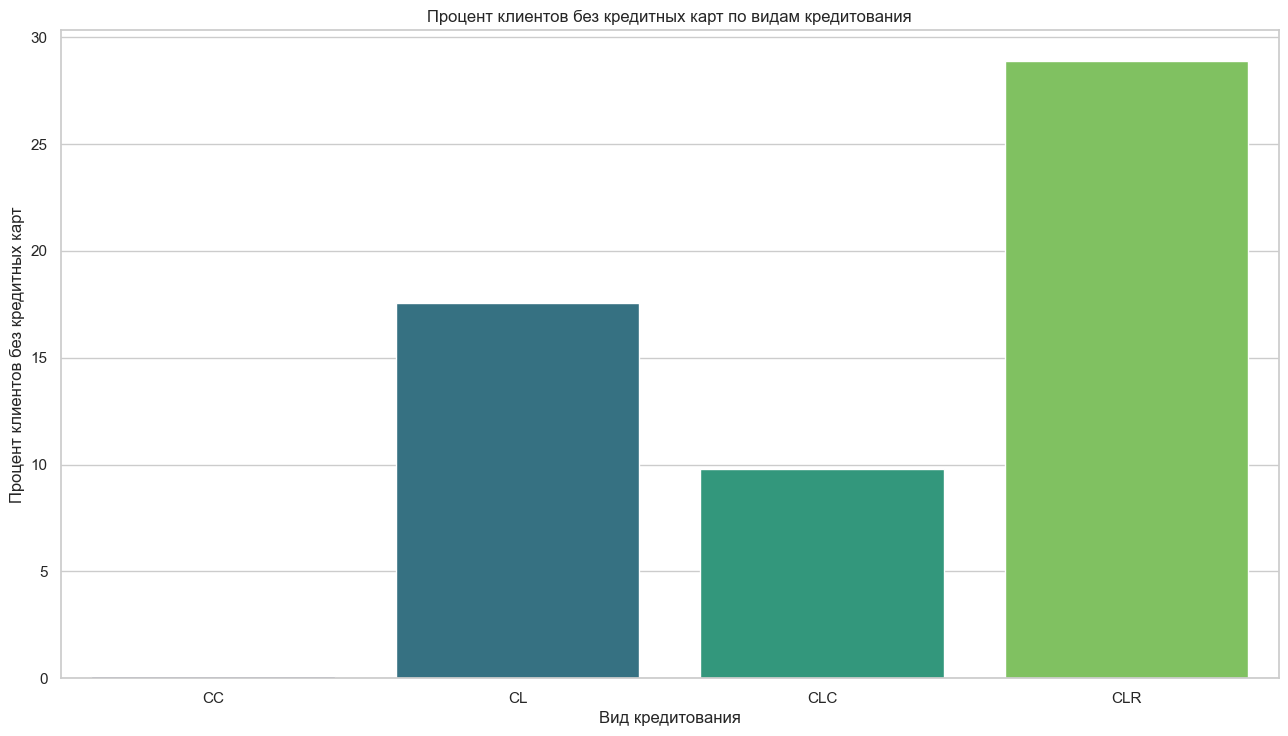

In [28]:
no_cc_counts = data.groupby("agreement_product_code")["cc_flg"].apply(
    lambda x: (x == 0).sum()
)
total_counts = data["agreement_product_code"].value_counts()

no_cc_percentage = (no_cc_counts / total_counts) * 100

# Создание таблицы с количеством и процентом клиентов без кредитных карт
no_cc_analysis = pd.DataFrame(
    {
        "Total": total_counts,
        "No_CC_Count": no_cc_counts,
        "No_CC_Percentage": no_cc_percentage,
    }
)

# Визуализация результатов
plt.figure(figsize=(14, 8))
sns.barplot(
    x=no_cc_analysis.index,
    y=no_cc_analysis["No_CC_Percentage"],
    hue=no_cc_analysis.index,
    palette="viridis",
    legend=False,
)
plt.title("Процент клиентов без кредитных карт по видам кредитования")
plt.xlabel("Вид кредитования")
plt.ylabel("Процент клиентов без кредитных карт")
plt.show()

### Основная гипотеза

Клиенты банка, имеющие кредитную карту (CC), чаще получают одобрение на все остальные кредитования.

### Рекомендации для банка

1. Продвигайте кредиты под залог автомобиля (CLC) клиентам с кредитными картами с лучшими условиями.
2. Используйте данные о кредитных картах для персонализированных предложений других кредитных продуктов.